In [601]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

import warnings
warnings.filterwarnings('ignore')

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import log_loss

from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.gaussian_process.kernels import ExpSineSquared

from hyperopt import fmin, hp, tpe, Trials

from copy import deepcopy

In [483]:
font = {'family' : 'helvetica',
        'weight' : 'normal',
        'size'   : 12}

plt.rc('font', **font)
plt.rcParams.update({'figure.autolayout': True})

In [2]:
# Opening the cleaned data:
with open('to_model_top_4_classes.pickle', 'rb') as f:
    to_model = pickle.load(f)

## Train / Test Split

In [4]:
X = to_model.drop(columns='Country.of.Origin')
y = to_model['Country.of.Origin']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, stratify=y, random_state=42)

In [5]:
X_train.sample(2)

,Aroma,Flavor,Aftertaste,Acidity,Body,Balance,Sweetness,Uniformity,Clean.Cup
1066,7.17,7.42,6.83,7.50,7.17,7.25,10.0,10.0,10.0
651,7.67,7.58,7.58,7.75,7.67,6.83,10.0,10.0,10.0


In [6]:
y_train.unique()

array(['Brazil', 'Guatemala', 'Colombia', 'Mexico'], dtype=object)

## Defining Error Metrics of Interest and setting up Cross Validation

In [6]:
def validate_model(unfitted_model):
    logloss = -1 * cross_val_score(unfitted_model, X_train, y_train, cv=8, scoring='neg_log_loss').mean()
    acc = cross_val_score(unfitted_model, X_train, y_train, cv=8, scoring='accuracy').mean()
    return logloss, acc

## Multinomial Logistic Regression

In [199]:
from sklearn.linear_model import LogisticRegression

In [200]:
model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)
predict_lr = model_lr.predict(X_test)

validate_model(model_lr)

(1.1912723051875245, 0.5436864405862243)

## K Nearest Neighbors

In [201]:
from sklearn.neighbors import KNeighborsClassifier

In [202]:
model_knn = KNeighborsClassifier()
model_knn.fit(X_train, y_train)
predict_knn = model_lr.predict(X_test)

validate_model(model_knn)

(6.033981029149847, 0.4833450519733865)

## Support Vector Machine Classifier

In [203]:
from sklearn.svm import SVC
model_svc = SVC(probability=True)
model_svc.fit(X_train,y_train)

validate_model(model_svc)

(1.1745026738232878, 0.4975404387805253)

## Random Forest

In [7]:
from sklearn.ensemble import RandomForestClassifier
model_rfc = RandomForestClassifier(random_state=4444, max_depth=4)
model_rfc.fit(X_train,y_train)
predict_rfc = model_rfc.predict(X_test)

cross_val_score(model_rfc, X_train, y_train, cv=8, scoring='neg_log_loss').mean()

-1.1651806198476231

In [8]:
with open('rfc_model.pickle', 'wb') as f:
    pickle.dump(model_rfc, f)

In [9]:
X_train.mean()

Aroma         7.537573
Flavor        7.491932
Aftertaste    7.348068
Acidity       7.515658
Body          7.485094
Balance       7.490872
Sweetness     9.933829
Uniformity    9.845692
Clean.Cup     9.818684
dtype: float64

In [10]:
model_rfc.classes_

array(['Brazil', 'Colombia', 'Guatemala', 'Mexico'], dtype=object)

In [11]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, predict_rfc, labels=['Brazil','Colombia','Guatemala','Mexico'])

In [12]:
y_test.value_counts()

Mexico       47
Colombia     37
Guatemala    36
Brazil       27
Name: Country.of.Origin, dtype: int64

In [13]:
class_dict = {'Brazil':0, 'Colombia':1, 'Guatemala':2, 'Mexico':3}

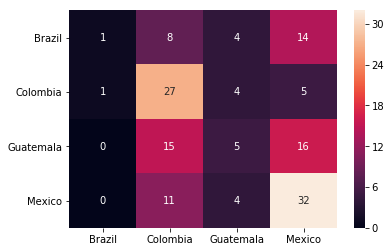

In [14]:
conf_heatmap = sns.heatmap(conf_mat, annot=True, xticklabels=['Brazil','Colombia','Guatemala','Mexico'], 
            yticklabels=['Brazil','Colombia','Guatemala','Mexico'])
conf_heatmap.figure.savefig('conf_heatmap.png')

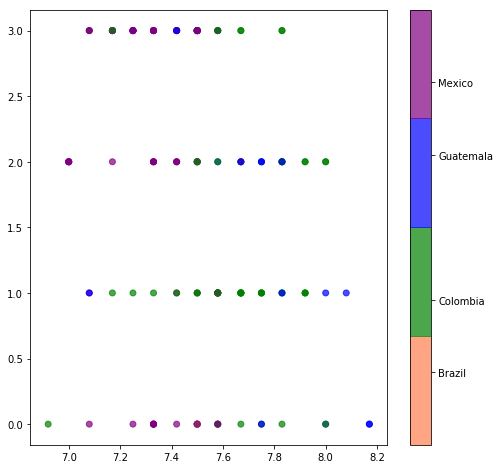

In [31]:
x = X_test['Body']
y = y_test.apply(lambda x: class_dict[x])
label = pd.Series(predict_rfc).apply(lambda x: class_dict[x])
colors = ['coral','green','blue','purple']
countries = ['Brazil','Colombia','Guatemala','Mexico']

fig = plt.figure(figsize=(8,8))
plt.scatter(x, y, c=label, cmap=matplotlib.colors.ListedColormap(colors), alpha=0.7)

cb = plt.colorbar()
loc = np.arange(0,max(label),max(label)/float(len(colors)))
cb.set_ticks([0.5,1,2,2.5])
cb.set_ticklabels(countries)
plt.savefig('label_scatter.png')

## Neural Net

In [213]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
ohe = LabelEncoder().fit(np.array(y_train).ravel())
y_train_t = ohe.transform(np.array(y_train).ravel())
y_test_t = ohe.transform(np.array(y_test).ravel())
y_train_t = np_utils.to_categorical(np.array(y_train_t).ravel())
y_test_t = np_utils.to_categorical(np.array(y_test_t).ravel())

In [214]:
y_train.head()

252        Brazil
1276    Guatemala
704      Colombia
819        Brazil
212      Colombia
Name: Country.of.Origin, dtype: object

In [215]:
y_train_t[0:5]

array([[1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.]], dtype=float32)

In [216]:
y_test_cat = y_test.apply(lambda x: 0 if x=='Brazil'
                                  else (1 if x=='Colombia'
                                  else (2 if x=='Guatemala'
                                       else 3)))

In [217]:
y_test.head()

470      Colombia
1113    Guatemala
397      Colombia
191     Guatemala
1190       Mexico
Name: Country.of.Origin, dtype: object

In [218]:
y_test_cat.head()

470     1
1113    2
397     1
191     2
1190    3
Name: Country.of.Origin, dtype: int64

In [219]:
from keras.models import Sequential
from keras.layers import Dense

In [220]:
X_train.shape

(585, 9)

In [221]:
model = Sequential()
model.add(Dense(20, input_dim=14, activation='tanh'))
model.add(Dense(4, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train_t, epochs=200, batch_size=10)

ValueError: Error when checking input: expected dense_3_input to have shape (14,) but got array with shape (9,)

In [222]:
evaluation = model.evaluate(X_test, y_test_t)
print("\nLoss on Test = %.3f, Accuracy on Test = %.3f"%(evaluation[0], evaluation[1]))

ValueError: Error when checking input: expected dense_3_input to have shape (14,) but got array with shape (9,)

In [223]:
y_pred_t = pd.DataFrame(model.predict_classes(X_test))

ValueError: Error when checking input: expected dense_3_input to have shape (14,) but got array with shape (9,)

In [224]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test_cat,y_pred_t)

NameError: name 'y_pred_t' is not defined

### Looking at Altitude as target variable

In [225]:
has_alt = arabica[~arabica.altitude_high_meters.isna()]

NameError: name 'arabica' is not defined

In [226]:
has_alt.unit_of_measurement.value_counts()

NameError: name 'has_alt' is not defined

In [227]:
has_alt = has_alt[has_alt.unit_of_measurement=='m']

NameError: name 'has_alt' is not defined

In [228]:
has_alt.altitude_high_meters.describe()

NameError: name 'has_alt' is not defined

In [229]:
has_alt.altitude_mean_meters.quantile(0.333333)

NameError: name 'has_alt' is not defined

In [42]:
has_alt.altitude_mean_meters.quantile(00.66666)

1550.0

In [43]:
has_alt['alt_type'] = has_alt['altitude_mean_meters'].apply(lambda x: 'low' if x<=1200 
                                                                       else ('med' if x<=1550 else 'high'))

In [44]:
columns_to_model = ['alt_type','Aroma',
       'Flavor', 'Aftertaste', 'Acidity', 'Body', 'Balance', 'Uniformity',
       'Clean.Cup', 'Sweetness', 'Cupper.Points', 'Total.Cup.Points',
       'Moisture', 'Category.One.Defects', 'Category.Two.Defects']

In [45]:
to_model = has_alt[columns_to_model]

In [46]:
X = to_model.drop(columns='alt_type')
y = to_model['alt_type']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)

In [47]:
X_train.shape

(681, 14)

In [48]:
model_lr = KNeighborsClassifier()
model_lr.fit(X_train, y_train)
predict_lr = model_lr.predict(X_test)

model_lr.score(X_test,y_test)

0.4452054794520548

In [60]:
from sklearn.svm import SVC
model_svc = SVC()
model_svc.fit(X_train,y_train)
predict_svc = model_svc.predict(X_test)
print(model_svc.score(X_test,y_test))

0.3048128342245989


In [50]:
from sklearn.ensemble import RandomForestClassifier
model_rfc = RandomForestClassifier(random_state=4444)
model_rfc.fit(X_train,y_train)
predict_rfc = model_rfc.predict(X_test)
print(model_rfc.score(X_test,y_test))

0.4554794520547945


In [51]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
ohe = LabelEncoder().fit(np.array(y_train).ravel())
y_train_t = ohe.transform(np.array(y_train).ravel())
y_test_t = ohe.transform(np.array(y_test).ravel())
y_train_t = np_utils.to_categorical(np.array(y_train_t).ravel())
y_test_t = np_utils.to_categorical(np.array(y_test_t).ravel())

In [52]:
model = Sequential()
model.add(Dense(20, input_dim=14, activation='relu'))
model.add(Dense(100, activation='tanh'))
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train_t, epochs=200, batch_size=3)

Epoch 1/200
681/681 [==============================] - 0s 516us/step - loss: 1.1620 - acc: 0.3201
Epoch 2/200
681/681 [==============================] - 0s 242us/step - loss: 1.1210 - acc: 0.3480
Epoch 3/200
681/681 [==============================] - 0s 247us/step - loss: 1.1145 - acc: 0.3275
Epoch 4/200
681/681 [==============================] - 0s 250us/step - loss: 1.1089 - acc: 0.3803
Epoch 5/200
681/681 [==============================] - 0s 247us/step - loss: 1.1083 - acc: 0.3319
Epoch 6/200
681/681 [==============================] - 0s 246us/step - loss: 1.1207 - acc: 0.3186
Epoch 7/200
681/681 [==============================] - 0s 280us/step - loss: 1.1073 - acc: 0.3847
Epoch 8/200
681/681 [==============================] - 0s 347us/step - loss: 1.1067 - acc: 0.3730
Epoch 9/200
681/681 [==============================] - 0s 346us/step - loss: 1.1208 - acc: 0.3319
Epoch 10/200
681/681 [==============================] - 0s 307us/step - loss: 1.1191 - acc: 0.3377
Epoch 11/200
681/68

## Make Pipeline to transform and fit data

In [8]:
from sklearn.ensemble import RandomForestClassifier

In [231]:
rfc_pipe = make_pipeline(StandardScaler(), RandomForestClassifier(random_state=4444, max_depth=4))

In [232]:
rfc_pipe.fit(X_train,y_train)


Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('randomforestclassifier', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_im...n_jobs=1,
            oob_score=False, random_state=4444, verbose=0,
            warm_start=False))])

In [233]:
validate_model(rfc_pipe)

(1.1651806198476231, 0.49050269176891387)

# Using Hyperopt to tune hyperparameters

In [132]:
rfc_class_weight_options = (None,"balanced")
svc_kernel_options = ('linear','rbf')

#### Tuning models separately

In [203]:
# random forest params
rfc_space = {
    'max_depth': hp.quniform('rfc_max_depth', 2, 7, 1),
    'class_weight': hp.choice('rfc_class_wt', rfc_class_weight_options),
    }

# support vector machine params
svc_space = {
    'C': hp.lognormal('svc_C', np.exp(0), np.exp(1)),
    'kernel': hp.choice('svc_kernel', svc_kernel_options),
    }

# elastic net logistic regression params
sgd_space = {
    'alpha': hp.uniform('sgd_alpha', 0.01, 1),
        'l1_ratio': hp.uniform('sgd_ratio', 0, 1)
    }

#gaussian process classifier
gpc_space = {
    'length_scale': hp.uniform('gpc_rbf_lscale', 0.05, 10)}

In [210]:
def rfc_score_fn(params):
    print(params)
    rfc_model = RandomForestClassifier(class_weight=params['class_weight'],
                                       max_depth=params['max_depth'],
                                       n_jobs=3)
    #technically don't need standard scaler for RFCs
    rfc_pipe = make_pipeline(StandardScaler(), rfc_model)
    logloss, acc = validate_model(rfc_pipe)
    return_dict = {'loss': logloss, 'accuracy': acc, 'status':'ok'}
    return return_dict

def svc_score_fn(params):
    print(params)
    svc_model = SVC(C=params['C'],
                    kernel=params['kernel'], 
                    probability=True)
    svc_pipe = make_pipeline(StandardScaler(), svc_model)
    logloss, acc = validate_model(svc_pipe)
    return_dict = {'loss': logloss, 'accuracy': acc, 'status':'ok'}
    return return_dict

def sgd_score_fn(params):
    print(params)
    sgd_model = SGDClassifier(penalty='elasticnet',
                              loss='log',
                              alpha=params['alpha'], 
                              l1_ratio=params['l1_ratio'],
                              n_jobs=3)
    
    sgd_pipe = make_pipeline(StandardScaler(), sgd_model)
    logloss, acc = validate_model(sgd_pipe)
    return_dict = {'loss': logloss, 'accuracy': acc, 'status':'ok'}
    return return_dict

def gpc_score_fn(params):
    print(params)
    gpc_model = GaussianProcessClassifier(RBF(params['length_scale']))
    gpc_pipe = make_pipeline(StandardScaler(), gpc_model)
    logloss, acc = validate_model(gpc_pipe)
    return_dict = {'loss': logloss, 'accuracy': acc, 'status':'ok'}
    return return_dict

In [211]:
gpc_trials = Trials()

In [212]:
y_test.count

{'length_scale': 6.367172176205978}
{'length_scale': 1.9639624344274782}
{'length_scale': 8.79959102690368}
{'length_scale': 0.42008623759510977}
{'length_scale': 6.199224276351474}
{'length_scale': 0.8815728812114394}
{'length_scale': 8.605012754694227}
{'length_scale': 9.6530969124371}
{'length_scale': 7.826774731808}
{'length_scale': 6.1003959572248085}
{'length_scale': 9.120832088843303}
{'length_scale': 8.27964524754095}
{'length_scale': 1.4777028101750191}
{'length_scale': 5.855735670706922}
{'length_scale': 0.9890776525877543}
{'length_scale': 7.494496814136168}
{'length_scale': 2.5205347730302954}
{'length_scale': 3.9561093582226055}
{'length_scale': 3.804470241761647}
{'length_scale': 6.5418085424474315}
{'length_scale': 4.6359671699217495}
{'length_scale': 4.4593652773949275}
{'length_scale': 4.544711972352601}
{'length_scale': 3.076395843854041}
{'length_scale': 5.067604280864951}
{'length_scale': 5.046628787620026}
{'length_scale': 5.215073119408626}
{'length_scale': 3.1578

In [213]:
scores_gpc = min((t for t in gpc_trials.results),
               key= lambda x: x['loss'])
scores_gpc

{'loss': 1.1523567856055439, 'accuracy': 0.5368095880667979, 'status': 'ok'}

In [241]:
rfc_trials = Trials()

In [242]:
# running hyperopt to retrieve optimum parameters
rfc_best = fmin(rfc_score_fn,
    space=rfc_space,
    algo=tpe.suggest,
    max_evals=30,
    trials=rfc_trials)

{'class_weight': 'balanced', 'max_depth': 3.0}
{'class_weight': None, 'max_depth': 2.0}
{'class_weight': None, 'max_depth': 6.0}
{'class_weight': 'balanced', 'max_depth': 3.0}
{'class_weight': 'balanced', 'max_depth': 6.0}
{'class_weight': None, 'max_depth': 6.0}
{'class_weight': None, 'max_depth': 6.0}
{'class_weight': None, 'max_depth': 2.0}
{'class_weight': 'balanced', 'max_depth': 4.0}
{'class_weight': 'balanced', 'max_depth': 5.0}
{'class_weight': None, 'max_depth': 7.0}
{'class_weight': None, 'max_depth': 5.0}
{'class_weight': 'balanced', 'max_depth': 7.0}
{'class_weight': None, 'max_depth': 2.0}
{'class_weight': 'balanced', 'max_depth': 3.0}
{'class_weight': 'balanced', 'max_depth': 3.0}
{'class_weight': 'balanced', 'max_depth': 3.0}
{'class_weight': 'balanced', 'max_depth': 6.0}
{'class_weight': 'balanced', 'max_depth': 7.0}
{'class_weight': 'balanced', 'max_depth': 7.0}
{'class_weight': None, 'max_depth': 6.0}
{'class_weight': None, 'max_depth': 5.0}
{'class_weight': None, 'ma

In [243]:
scores_rfc = min((t for t in rfc_trials.results),
               key= lambda x: x['loss'])
scores_rfc

{'loss': 1.1390173591580006, 'accuracy': 0.49379463502796234, 'status': 'ok'}

In [246]:
svc_trials = Trials()

In [247]:
svc_best = fmin(svc_score_fn,
    space=svc_space,
    algo=tpe.suggest,
    max_evals=100,
    trials=svc_trials)

{'C': 2.9069360729340032, 'kernel': 'linear'}
{'C': 134.23737519851838, 'kernel': 'rbf'}
{'C': 0.05627406328678686, 'kernel': 'rbf'}
{'C': 0.1517950879469844, 'kernel': 'rbf'}
{'C': 0.08190786605287667, 'kernel': 'linear'}
{'C': 22.041858165307094, 'kernel': 'linear'}
{'C': 7.684194459049488, 'kernel': 'rbf'}
{'C': 13.932355283665542, 'kernel': 'rbf'}
{'C': 203.77427582385752, 'kernel': 'linear'}
{'C': 1.1455350393922994, 'kernel': 'linear'}
{'C': 25.46202480826359, 'kernel': 'rbf'}
{'C': 0.05155399627804399, 'kernel': 'rbf'}
{'C': 0.022365359774147962, 'kernel': 'linear'}
{'C': 33.14279695853066, 'kernel': 'linear'}
{'C': 32.76030187064162, 'kernel': 'rbf'}
{'C': 0.12260400919925125, 'kernel': 'rbf'}
{'C': 2.3069692760254736, 'kernel': 'rbf'}
{'C': 0.2344862874877376, 'kernel': 'linear'}
{'C': 0.369573671588658, 'kernel': 'linear'}
{'C': 0.325148527329173, 'kernel': 'rbf'}
{'C': 2.975327981904281, 'kernel': 'rbf'}
{'C': 2.638367682200394, 'kernel': 'rbf'}
{'C': 2.6514807821945503, 'ke

In [248]:
svc_best.items()

dict_items([('svc_C', 1.7032838507567418), ('svc_kernel', 1)])

In [249]:
scores_svc = min((t for t in svc_trials.results),
               key= lambda x: x['loss'])
scores_svc

{'loss': 1.0970882475473012, 'accuracy': 0.5485317464183722, 'status': 'ok'}

In [250]:
sgd_trials = Trials()

In [251]:
sgd_best = fmin(sgd_score_fn,
    space=sgd_space,
    algo=tpe.suggest,
    max_evals=100,
    trials=sgd_trials)

{'alpha': 0.03386541342064317, 'l1_ratio': 0.8370326464973079}
{'alpha': 0.27595908138360226, 'l1_ratio': 0.4685616189501838}
{'alpha': 0.7651663491405363, 'l1_ratio': 0.2357712194382966}
{'alpha': 0.22670885037404756, 'l1_ratio': 0.3978479819428088}
{'alpha': 0.9845293319924917, 'l1_ratio': 0.9705822679492873}
{'alpha': 0.9045903145235542, 'l1_ratio': 0.19993633683646184}
{'alpha': 0.6295230676694133, 'l1_ratio': 0.0576930220311066}
{'alpha': 0.8347058125303128, 'l1_ratio': 0.022216063867770308}
{'alpha': 0.7057414694415782, 'l1_ratio': 0.37994028420387094}
{'alpha': 0.9971456214962058, 'l1_ratio': 0.8367922838292607}
{'alpha': 0.48878886958933626, 'l1_ratio': 0.8998465159663666}
{'alpha': 0.6492670443421716, 'l1_ratio': 0.4625381630988744}
{'alpha': 0.3612079992787739, 'l1_ratio': 0.6866276106130597}
{'alpha': 0.1721091071709561, 'l1_ratio': 0.1289478860535732}
{'alpha': 0.961647283429547, 'l1_ratio': 0.13586145368407376}
{'alpha': 0.1995885389571916, 'l1_ratio': 0.4222190417991446}


In [252]:
scores_sgd = min((t for t in sgd_trials.results),
               key= lambda x: x['loss'])
scores_sgd

{'loss': 1.1781252028558353, 'accuracy': 0.5300084804523341, 'status': 'ok'}

In [ ]:
# VotingClassifier([('rfc', rfc_model),('svc', svc_model),('sgd', sgd_model)],
#                                                            voting='soft',
#                                                            n_jobs=3)

### implementing optimized hyperparameters to investigate performance

In [253]:
rfc_class_weight_options = (None,"balanced")
svc_kernel_options = ('linear','rbf')

sgd_model = SGDClassifier(penalty='elasticnet',
                          loss='log',
                          alpha=sgd_best['sgd_alpha'], 
                          l1_ratio=sgd_best['sgd_ratio'])

# rfc_class_wt is 0, which is not allowed in this implementation!:
rfc_model = RandomForestClassifier(class_weight=rfc_class_weight_options[rfc_best['rfc_class_wt']],
                                   max_depth=rfc_best['rfc_max_depth'])

svc_model = svc_model = SVC(C=svc_best['svc_C'], 
                            kernel=svc_kernel_options[svc_best['svc_kernel']], 
                            probability=True)

rfc_pipe = make_pipeline(StandardScaler(), rfc_model)
svc_pipe = make_pipeline(StandardScaler(), svc_model)
sgd_pipe = make_pipeline(StandardScaler(), sgd_model)


In [254]:
# Create validation set
X_train_subset, X_val, y_train_subset, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train)

In [255]:
rfc_pipe.fit(X_train_subset, y_train_subset)
rfc_y_pred = rfc_pipe.predict(X_val)

In [256]:
svc_pipe.fit(X_train_subset, y_train_subset)
svc_y_pred = svc_pipe.predict(X_val)

In [257]:
sgd_pipe.fit(X_train_subset, y_train_subset)
sgd_y_pred = sgd_pipe.predict(X_val)

### running classification reports

In [258]:
print(classification_report(y_val, svc_y_pred))

             precision    recall  f1-score   support

     Brazil       0.38      0.29      0.32        21
   Colombia       0.68      0.79      0.73        29
  Guatemala       0.79      0.38      0.51        29
     Mexico       0.53      0.74      0.62        38

avg / total       0.60      0.58      0.57       117



In [259]:
print(classification_report(y_val, rfc_y_pred))

             precision    recall  f1-score   support

     Brazil       0.25      0.10      0.14        21
   Colombia       0.67      0.83      0.74        29
  Guatemala       0.35      0.24      0.29        29
     Mexico       0.49      0.68      0.57        38

avg / total       0.46      0.50      0.46       117



In [260]:
print(classification_report(y_val, sgd_y_pred))

             precision    recall  f1-score   support

     Brazil       0.00      0.00      0.00        21
   Colombia       0.59      0.83      0.69        29
  Guatemala       0.54      0.48      0.51        29
     Mexico       0.57      0.68      0.62        38

avg / total       0.46      0.55      0.50       117



#### Optimizing over 3 models at once (choosing best with hyperopt)

In [500]:
class_weight_options = (None,"balanced")
svc_kernel_options = ('linear','rbf', 'poly', 'sigmoid')
svc_kernel_dicts = [{'kernel': 'linear'}, ]
sgd_penalty_options = ('l1', 'l2', 'elasticnet')
criterion_options = ('gini', 'entropy')
model_options = ('rfc', 'svc', 'sgd', 'gnc', 'gnb', 'dtc')

opt_space = {'model': hp.choice('model_type',
                      [{'type': 'rfc',
                        'max_depth': hp.quniform('rfc_max_depth', 2, 7, 1),
                        'class_weight': hp.choice('rfc_class_wt', rfc_class_weight_options),
                       },
                       {'type': 'svc',
                        'C': hp.lognormal('svc_C', 0, 1),
                        'kernel': hp.choice('svc_kernel', svc_kernel_options)   
                       },
                       {'type': 'sgd',
                        'alpha': hp.uniform('sgd_alpha', 0.01, 1),
                        'l1_ratio': hp.uniform('sgd_ratio', 0, 1)
                       }
                      ]),
             'n_components': hp.quniform('num_pc', 1, 8, 1)
            }

In [501]:
opt_space = hp.choice('model_type',
                      [{'type': 'rfc',
                        'max_depth': hp.quniform('rfc_max_depth', 2, 10, 1),
                        'class_weight': hp.choice('rfc_class_wt', class_weight_options),
                        'n_estimators': hp.quniform('rfc_n_ests', 5, 75, 5),
                        'criterion': hp.choice('rfc_criterion', criterion_options),
                        'min_samples_leaf': hp.uniform('rfc_min_samples', 0.05, 0.5),
                       },
                       {'type': 'svc',
                        'C': hp.lognormal('svc_C', 0, 1),
                        'class_weight': hp.choice('svc_class_wt', class_weight_options),
                        'kernel': hp.choice('svc_kernel', 
                                            [{'kernel': 'linear'},
                                             {'kernel': 'rbf',
                                              'gamma': hp.uniform('svc_gamma_rbf', 0.01, 1)},
                                             {'kernel': 'poly',
                                              'degree': hp.quniform('svc_degree', 2, 5, 1),
                                              'gamma': hp.uniform('svc_gamma_poly', 0.01, 1)},
                                             {'kernel': 'sigmoid',
                                              'gamma': hp.uniform('svc_gamma_sigmoid', 0.01, 1)}
                                            ])   
                       },
                       {'type': 'sgd',
                        'alpha': hp.uniform('sgd_alpha', 0.01, 1),
                        'penalty': hp.choice('sgd_penalty', sgd_penalty_options),
                        'l1_ratio': hp.uniform('sgd_ratio', 0, 1)
                       },
                       {'type': 'gpc',
                        'length_scale': hp.uniform('gpc_lscale', 0.05, 7)
                       },
                       #{'type': 'gnb'},
                       {'type': 'dtc',
                        'criterion': hp.choice('dtc_criterion', criterion_options),
                        'max_depth': hp.quniform('dtc_max_depth', 3, 20, 1),
                        'min_samples_leaf': hp.uniform('dtc_min_samples', 0.05, 0.5),
                        'class_weight': hp.choice('dtc_class_wt', class_weight_options),
                       }
                      ])

In [502]:
def pipe_from_params(params):
    
    model_params = deepcopy(params)
    
    for key in params.keys():
        if type(model_params[key]) == dict:
            sub_dict = model_params.pop(key)
            model_params.update(sub_dict)
    
    model_type = model_params.pop('type')
    
    if model_type == 'rfc':
        model_params['max_depth'] = int(model_params['max_depth'])
        model_params['n_estimators'] = int(model_params['n_estimators'])
        model = RandomForestClassifier(n_jobs=3,
                                       **model_params)
    elif model_type == 'svc':
        model = SVC(probability=True,
                   **model_params)
        
    elif model_type == 'sgd':
        model = SGDClassifier(loss='log',
                              n_jobs=3,
                              **model_params)
        
    elif model_type == 'gpc':
        model = GaussianProcessClassifier(RBF(model_params['length_scale']))
        
    elif model_type == 'gnb':
        model = GaussianNB()
        
    elif model_type == 'dtc':
        model_params['max_depth'] = int(model_params['max_depth'])
        model = DecisionTreeClassifier(**model_params)
    
    pipe = make_pipeline(StandardScaler(), model)
    return pipe

In [503]:
def score_fn(params):
    print(params)
    
    pipe = pipe_from_params(params)
    
    logloss, acc = validate_model(pipe)
    return_dict = {'loss': logloss, 'accuracy': acc, 'status':'ok'}
    print(return_dict)
    return return_dict

In [504]:
model_choice_trials = Trials()

In [560]:
warnings.filterwarnings('ignore')
best_model_choice = fmin(score_fn,
                         space=opt_space,
                         algo=tpe.suggest,
                         max_evals=2000,
                         trials=model_choice_trials)

{'class_weight': None, 'criterion': 'entropy', 'max_depth': 6.0, 'min_samples_leaf': 0.09517193725886772, 'type': 'dtc'}
{'loss': 1.232738695315994, 'accuracy': 0.4550425402872231, 'status': 'ok'}
{'C': 5.247056133792669, 'class_weight': 'balanced', 'kernel': {'gamma': 0.10314431148477257, 'kernel': 'rbf'}, 'type': 'svc'}
{'loss': 1.1047531035932958, 'accuracy': 0.5173599608981728, 'status': 'ok'}
{'C': 4.824099504053451, 'class_weight': 'balanced', 'kernel': {'gamma': 0.05372682513786788, 'kernel': 'rbf'}, 'type': 'svc'}
{'loss': 1.0929964787543538, 'accuracy': 0.5294852012250174, 'status': 'ok'}
{'length_scale': 5.301512648430599, 'type': 'gpc'}
{'loss': 1.152356828494582, 'accuracy': 0.5368095880667979, 'status': 'ok'}
{'C': 4.190423574402326, 'class_weight': None, 'kernel': {'gamma': 0.025631286539222375, 'kernel': 'rbf'}, 'type': 'svc'}
{'loss': 1.1120204135856921, 'accuracy': 0.5501977960296274, 'status': 'ok'}
{'C': 4.3196102960686265, 'class_weight': 'balanced', 'kernel': {'gam

In [565]:
loss_model_choice = min((t for t in model_choice_trials.results), 
                        key= lambda x: x['loss'])

In [566]:
best_model_choice.items()

dict_items([('model_type', 1), ('svc_C', 4.907407475117302), ('svc_class_wt', 1), ('svc_gamma_rbf', 0.041596476259419986), ('svc_kernel', 1)])

In [567]:
loss_model_choice

{'loss': 1.0875375999197772, 'accuracy': 0.5309878867692495, 'status': 'ok'}

In [568]:
with open('best_model_choice_1.pickle', 'wb') as f:
    pickle.dump(best_model_choice, f)

#### Combining 3 models with voting:

In [15]:
opt_space = {
    # model averaging params
    
    # random forest params
    'max_depth': hp.quniform('rfc_max_depth', 2, 7, 1),
    'class_weight': hp.choice('rfc_class_wt', rfc_class_weight_options),
    
    # support vector machine params
            'C': hp.lognormal('svc_C', 0, 1),
        'kernel': hp.choice('svc_kernel', svc_kernel_options),
    
    # elastic net logistic regression params
        'alpha': hp.uniform('sgd_alpha', 0.01, 1),
        'l1_ratio': hp.uniform('sgd_ratio', 0, 1)
    }

In [17]:
3_model_average_trials = Trials()

In [16]:
def score_fn(params):
    print(params)
    rfc_model = RandomForestClassifier(class_weight=params['class_weight'],
                                       max_depth=params['max_depth'])
    svc_model = SVC(C=params['C'], 
                    kernel=params['kernel'], 
                    probability=True)
    sgd_model = SGDClassifier(penalty='elasticnet',
                              loss='log',
                              alpha=params['alpha'], 
                              l1_ratio=params['l1_ratio'])
    
    pipe = make_pipeline(StandardScaler(), VotingClassifier([('rfc', rfc_model),('svc', svc_model),('sgd', sgd_model)],
                                                           voting='soft',
                                                           n_jobs=3))
    # for loop used to fit model 3 times, 
        # aiming to reduce variance of chosen model by averaging results
    # losses = []
    # for i in range(3):
    #    logloss, _ = validate_model(pipe)
    #    losses.append(logloss)
    # return np.mean(losses)
    
    logloss, acc = validate_model(pipe)
    return_dict = {'loss': logloss, 'accuracy': acc, 'status':'ok'}
    return return_dict

In [17]:
3_model_average_trials = Trials()

In [ ]:
best_3_model_average = fmin(score_fn,
                            space=opt_space,
                            algo=tpe.suggest,
                            max_evals=500,
                            trials=3_model_average_trials)

In [ ]:
loss_3_model_average = min((t for t in 3_model_average_trials.results), 
                           key= lambda x: x['loss'])

In [22]:
best_3_model_average.items()

dict_items([('rfc_class_wt', 0), ('rfc_max_depth', 7.0), ('sgd_alpha', 0.010539786505872572), ('sgd_ratio', 0.0014216596194842057), ('svc_C', 5.507782328751656), ('svc_kernel', 1)])

In [67]:
# from initial run selecting from models
best.items()

dict_items([('rfc_class_wt', 0), ('rfc_max_depth', 8.0), ('sgd_alpha', 0.010229842208984985), ('sgd_ratio', 0.4188119344512063), ('svc_C', 5.465872847016365), ('svc_kernel', 1)])

In [ ]:
min((t for t in trials.results), key= lambda x: x['loss'])

In [180]:
## Note: with top 18 countries, my best model was 
## SVC(C=1.976739553459949, kernel = 'rbf'])
## {'loss': 2.2062940176075414, 'accuracy': 0.3471951411055378, 'status': 'ok'}

## Note: with top 6 countries, my best model was
## SVC(C=1.4143304319182868, kernel = 'rbf'])
## {'loss': 1.4168561022650243, 'accuracy': 0.4670597725598205, 'status': 'ok'}

## Note: with top 4 countries, my best model was
## SVC(C=1.8407176183255418, kernel='rbf')
## {'loss': 1.0963919629609573, 'accuracy': 0.5518888120276008, 'status': 'ok'}


## Plotting Hyperparameter Tuning

In [569]:
losses = model_choice_trials.losses()

In [570]:
trials, model_types = zip(*((trial_n, trial_dict['misc']['vals']['model_type']) for trial_n, trial_dict in enumerate(model_choice_trials.trials)))

In [571]:
model_choice_trials.trials[2]['misc']['vals']['model_type']

[4]

In [572]:
%matplotlib inline

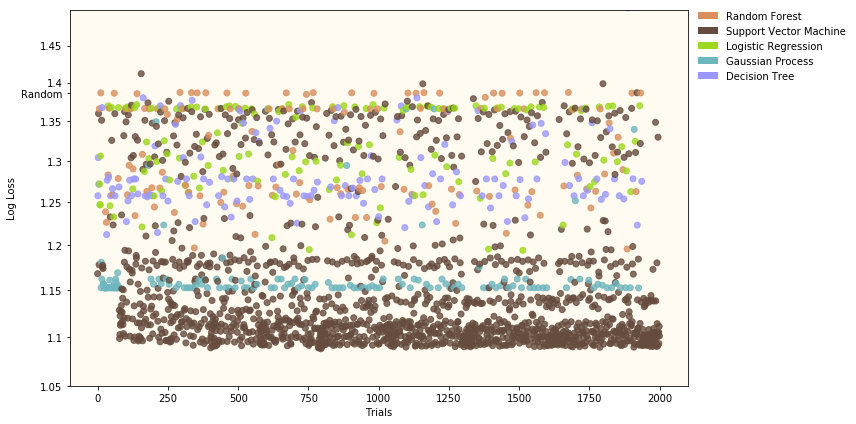

In [722]:
import matplotlib.patches as mpatches

x = list(trials)
y = list(losses)
classifiers = ('Random Forest', 'Support Vector Machine', 'Logistic Regression', 
               'Gaussian Process', 'Decision Tree')
label = list((num_list[0] for num_list in model_types))
colors = ['#d98f5e', '#664C3e', '#9cd81e', '#6eb6be', '#9b98fd']
cmap = matplotlib.colors.ListedColormap(colors)
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(1, 1, 1)
plt.scatter(x, y, c=label, cmap=cmap, alpha=0.8)
plt.yscale('log')
plt.ylim(1.05,1.5)
plt.yticks([1.05, 1.1, 1.15, 1.2, 1.25, 1.3, 1.35, 1.3862 , 1.4, 1.45],
           ['1.05', '1.1', '1.15', '1.2', '1.25', '1.3', '1.35', 'Random', '1.4', '1.45'])
plt.ylabel('Log Loss')
plt.xlabel('Trials')

#ax.xaxis.label.set_fontsize(12)
#ax.yaxis.label.set_fontsize(12)


ax.set_facecolor('#fffbf0')

c = [mpatches.Circle((0.5, 0.5), radius = 0.25, facecolor=colors[i], edgecolor="none") for i in range(len(classifiers))]
plt.legend(c,classifiers,loc=(1.01,0.8), facecolor='none', edgecolor='none')

#cb = plt.colorbar()
#loc = np.arange(0,max(label),max(label)/float(len(colors)))
#cb.set_ticks([0.5,1.5,2.2,3,4,5])
#cb.set_ticklabels(classifiers)
plt.savefig('hyperopt1.png', transparent=True)
plt.show()

In [575]:
type(trials)

tuple

In [576]:
type(losses)

list

## Implementing best model

In [577]:
best_pipeline = make_pipeline(StandardScaler(), SVC(kernel='rbf', 
                                                    gamma=best_model_choice['svc_gamma_rbf'], 
                                                    C=best_model_choice['svc_C'],
                                                    probability = True))
best_pipeline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svc', SVC(C=4.907407475117302, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.041596476259419986,
  kernel='rbf', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False))])

In [578]:
y_pred = best_pipeline.predict(X_test)

In [739]:
pd.Series(y_pred).apply(lambda x: class_dict[x]).values

array([1, 3, 1, 1, 3, 2, 3, 0, 3, 3, 3, 3, 1, 3, 2, 3, 3, 0, 3, 1, 1, 3,
       1, 3, 1, 2, 0, 1, 3, 3, 2, 3, 1, 3, 2, 1, 3, 1, 1, 2, 1, 1, 0, 3,
       1, 2, 0, 2, 2, 3, 3, 2, 3, 3, 2, 2, 1, 3, 1, 1, 1, 3, 3, 3, 3, 2,
       3, 2, 2, 2, 1, 2, 3, 1, 1, 1, 3, 3, 1, 0, 1, 3, 3, 3, 3, 3, 1, 3,
       1, 1, 3, 2, 1, 1, 2, 1, 0, 3, 2, 1, 2, 3, 2, 2, 1, 2, 2, 1, 2, 3,
       0, 3, 1, 3, 2, 1, 0, 3, 1, 3, 1, 2, 3, 3, 1, 3, 3, 3, 1, 1, 2, 1,
       3, 3, 2, 1, 3, 2, 0, 3, 2, 3, 3, 1, 3, 3, 3])

In [741]:
pd.Series(y_test).apply(lambda x: class_dict[x]).values

array([1, 2, 1, 2, 3, 1, 3, 0, 0, 3, 3, 3, 0, 3, 3, 3, 3, 1, 2, 1, 0, 0,
       1, 3, 1, 2, 1, 1, 3, 3, 3, 0, 2, 3, 2, 1, 3, 2, 2, 2, 1, 1, 0, 3,
       2, 2, 0, 2, 2, 0, 2, 3, 2, 3, 0, 2, 0, 0, 0, 1, 2, 2, 1, 1, 3, 2,
       0, 2, 2, 2, 0, 0, 3, 2, 1, 3, 1, 2, 2, 2, 1, 3, 2, 0, 3, 3, 1, 0,
       1, 3, 0, 1, 1, 1, 2, 0, 0, 3, 2, 3, 2, 3, 2, 3, 1, 2, 3, 3, 2, 0,
       3, 3, 1, 1, 2, 0, 0, 3, 1, 3, 3, 2, 3, 1, 1, 3, 3, 3, 3, 1, 0, 1,
       0, 3, 1, 1, 3, 1, 3, 1, 1, 3, 3, 1, 0, 2, 3])

In [742]:
y_pred_t = pd.get_dummies(pd.Series(y_pred),)
y_test_t = pd.Series(y_test).apply(lambda x: class_dict[x]).values

accuracy_score(y_test, y_pred)

0.5578231292517006

## Plotting Results of SVM Classifier:

In [579]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred, labels=['Brazil','Colombia','Guatemala','Mexico'])

In [580]:
class_dict = {'Brazil':0, 'Colombia':1, 'Guatemala':2, 'Mexico':3}

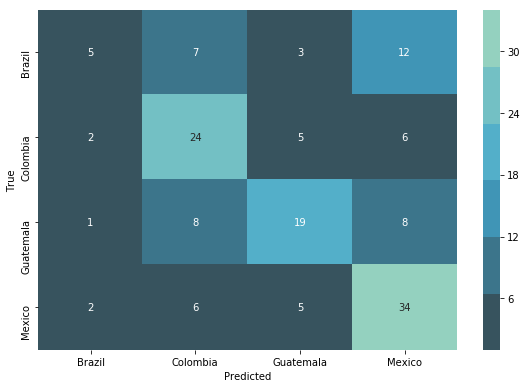

In [581]:
plt.figure(figsize = (8,5.5))
conf_heatmap = sns.heatmap(conf_mat, annot=True, xticklabels=['Brazil','Colombia','Guatemala','Mexico'], 
                           yticklabels=['Brazil','Colombia','Guatemala','Mexico'],
                           cmap = sns.color_palette("GnBu_d"))
plt.xlabel('Predicted')
plt.ylabel('True')
conf_heatmap.figure.savefig('conf_heatmap1.png', transparent=True)

In [582]:
y_test.value_counts()

Mexico       47
Colombia     37
Guatemala    36
Brazil       27
Name: Country.of.Origin, dtype: int64

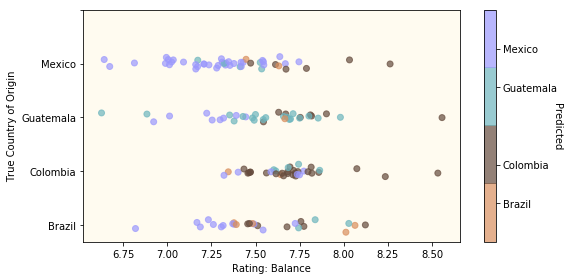

In [703]:
# add jitter
def rand_jitter(arr):
    stdev = .02*(max(arr)-min(arr))
    return arr + np.random.randn(len(arr)) * stdev

x = X_test['Balance']
x = rand_jitter(x)
y = y_test.apply(lambda x: class_dict[x])
y = rand_jitter(y)
label = pd.Series(y_pred).apply(lambda x: class_dict[x])
colors = ['#d98f5e', '#664C3e', '#6eb6be', '#9b98fd']
countries = ['Brazil','Colombia','Guatemala','Mexico']

fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(1, 1, 1)
ax.set_facecolor('#fffbf0')

plt.scatter(x, y, c=label, cmap=matplotlib.colors.ListedColormap(colors), alpha=0.7)

plt.yticks([0,1,2,3,4], countries)
plt.ylabel('True Country of Origin')
plt.xlabel('Rating: Balance')

cb = plt.colorbar()
cb.set_label('Predicted', rotation=270)
loc = np.arange(0,max(label),max(label)/float(len(colors)))
cb.set_ticks([0.5,1,2,2.5])
cb.set_ticklabels(countries)
plt.savefig('label_scatter1.png', transparent=True)

## Permutation Importance: Gaining Insight into Feature Importance

In [614]:
class_dict = {'Brazil':0, 'Colombia':1, 'Guatemala':2, 'Mexico':3}

In [670]:
def perm_import(fitted_pipeline, X_test, y_test):
    y_pred = fitted_pipeline.predict_proba(X_test)
    y_test_n = [class_dict[country] for country in y_test]
    y_test_n = pd.get_dummies(y_test_n)
    
    loss = log_loss(y_test_n, y_pred)
    print(loss)
    
    feature_importances = {}
    for feat in X_test.columns:
        X_test_copy = deepcopy(X_test)
        feat_to_randomize = deepcopy(X_test[feat])
        feat_to_randomize = feat_to_randomize.sample(frac=1)
        feat_to_randomize.reset_index(inplace=True, drop=True)
        X_test_copy.loc[:,feat] = feat_to_randomize.values
        
        y_pred = fitted_pipeline.predict_proba(X_test_copy)
        feat_loss = log_loss(y_test_n, y_pred)
        feat_import = feat_loss - loss
        feature_importances[feat] = feat_import
        
    return feature_importances
    
    

In [671]:
best_model_choice.items()

dict_items([('model_type', 1), ('svc_C', 4.907407475117302), ('svc_class_wt', 1), ('svc_gamma_rbf', 0.041596476259419986), ('svc_kernel', 1)])

In [672]:
feature_importances = perm_import(best_pipeline, X_test, y_test)

1.1116275577089507


In [673]:
feature_importances

{'Aroma': 0.12974963285426688,
 'Flavor': 0.12986393224749793,
 'Aftertaste': 0.297953623431086,
 'Acidity': 0.11474525186340512,
 'Body': 0.13717283406064418,
 'Balance': 0.20671520759942474,
 'Sweetness': 0.008909692224236654,
 'Uniformity': 0.03899295746267728,
 'Clean.Cup': 0.022873536880897216}

In [656]:
#with open('best_pipeline_no_gpctune.pickle', 'wb') as f:
#    pickle.dump(best_pipeline, f)
#with open('feat_imp_no_gpctune.pickle', 'wb') as f:
#    pickle.dump(feature_importances, f)


In [674]:
feats_by_importance = sorted(feature_importances.items(), key= lambda x: x[1], reverse=True)
feats_by_importance

[('Aftertaste', 0.297953623431086),
 ('Balance', 0.20671520759942474),
 ('Body', 0.13717283406064418),
 ('Flavor', 0.12986393224749793),
 ('Aroma', 0.12974963285426688),
 ('Acidity', 0.11474525186340512),
 ('Uniformity', 0.03899295746267728),
 ('Clean.Cup', 0.022873536880897216),
 ('Sweetness', 0.008909692224236654)]

In [675]:
feats, perm_imps = zip(*(feats_by_importance))

In [678]:
perm_imps

(0.297953623431086,
 0.20671520759942474,
 0.13717283406064418,
 0.12986393224749793,
 0.12974963285426688,
 0.11474525186340512,
 0.03899295746267728,
 0.022873536880897216,
 0.008909692224236654)

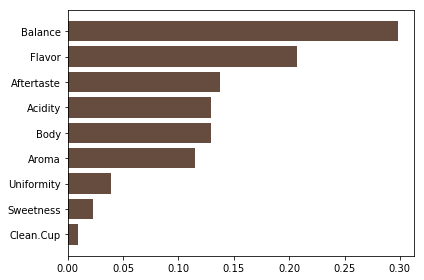

In [718]:
plt.barh(y=sorted(range(len(feats)), reverse=True), width=perm_imps, height=0.8, tick_label=feat, color='#664C3e')
plt.savefig('feat_importances1.png', transparent=True)

In [744]:
to_model.mean()

Aroma         7.545260
Flavor        7.495820
Aftertaste    7.350123
Acidity       7.517801
Body          7.490874
Balance       7.495109
Sweetness     9.938019
Uniformity    9.843866
Clean.Cup     9.822336
dtype: float64

In [553]:
to_model.groupby(by='Country.of.Origin').agg([np.mean, np.std])

Aroma              Flavor           Aftertaste  \
                       mean       std      mean       std       mean   
Country.of.Origin                                                      
Brazil             7.553106  0.327135  7.573561  0.277525   7.440530   
Colombia           7.653060  0.268421  7.597104  0.176936   7.524699   
Guatemala          7.544862  0.310297  7.489006  0.372653   7.266851   
Mexico             7.457585  0.274343  7.379025  0.328595   7.228051   

                              Acidity                Body             Balance  \
                        std      mean       std      mean       std      mean   
Country.of.Origin                                                               
Brazil             0.273022  7.511439  0.258676  7.544545  0.252754  7.531515   
Colombia           0.210470  7.560000  0.283138  7.609508  0.270332  7.708415   
Guatemala          0.376273  7.596409  0.278054  7.475746  0.295157  7.469890   
Mexico             0.315775  7.428347  0.266398  7.380466  0.212731  7.328686   

                            Sweetness           Uniformity            \
                        std      mean       std       mean       std   
Country.of.Origin                                                      
Brazil             0.297861  9.949394  0.314962   9.884924  0.475702   
Colombia           0.259393  9.952678  0.363029   9.934426  0.383193   
Guatemala          0.322361  9.870884  0.696395   9.852486  0.407275   
Mexico             0.313179  9.971780  0.219766   9.744068  0.600346   

                  Clean.Cup            
                       mean       std  
Country.of.Origin                      
Brazil             9.853485  0.612465  
Colombia           9.945355  0.368744  
Guatemala          9.889337  0.687100  
Mexico             9.658136  1.210437

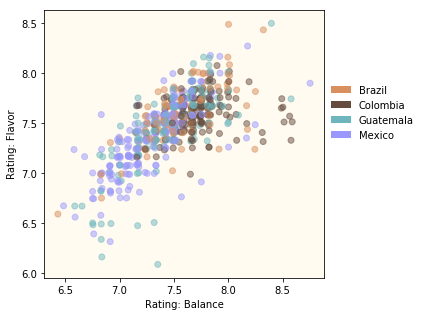

In [704]:
# add jitter
def rand_jitter(arr):
    stdev = .005*(max(arr)-min(arr))
    return arr + np.random.randn(len(arr)) * stdev

class_dict = {'Brazil':0, 'Colombia':1, 'Guatemala':2, 'Mexico':3}

feat1 = 'Balance'
feat2 = 'Flavor'


x = X[feat1]
x = rand_jitter(x)
y = X[feat2]
y = rand_jitter(y)
label = pd.Series(to_model['Country.of.Origin']).apply(lambda x: class_dict[x])
colors = ['#d98f5e', '#664C3e', '#6eb6be', '#9b98fd']
countries = ['Brazil','Colombia','Guatemala','Mexico']

fig = plt.figure(figsize=(6,4.5))
ax = fig.add_subplot(1, 1, 1)
ax.set_facecolor('#fffbf0')

plt.scatter(x, y, c=label, cmap=matplotlib.colors.ListedColormap(colors), alpha=0.5)
#plt.xlim(6.5,8.5)
plt.xlabel('Rating: '+ feat1)
plt.ylabel('Rating: '+ feat2)

c = [mpatches.Circle((0.5, 0.5), radius = 0.25, facecolor=colors[i], edgecolor="none") for i in range(len(countries))]
plt.legend(c,countries,loc=(1.01,0.5), facecolor='none', edgecolor='none')
plt.savefig('feat1VSfeat2.png', transparent=True)
plt.show()

In [715]:
range(len(countries))

range(0, 4)

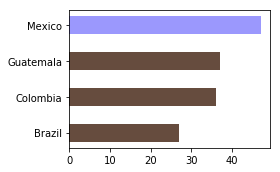

In [731]:
plt.figure(figsize=(4,2.5))
plt.barh(width = sorted(list(y_test.value_counts())), y=range(len(countries)), height=0.5, tick_label=countries, color=['#664C3e','#664C3e','#664C3e','#9b98fd'])
plt.savefig('country_counts1.png', transparent=True)

In [712]:
list(y_test.value_counts())

[47, 37, 36, 27]